## UNSW_NB15 Dataset

The raw network packets of the UNSW-NB 15 dataset was created by the IXIA PerfectStorm tool in the Cyber Range Lab of the Australian Centre <br> for Cyber Security (ACCS) for generating a hybrid of real modern normal activities and synthetic contemporary attack behaviours.

In [1]:
%load_ext autoreload

In [2]:
%autoreload
%matplotlib inline

import numpy as np
import torch
import torch.nn.functional as F

from modules.lib import convert_to_float32

from support.torch import (
    TorchMLP
)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.optim import AdamW, Adam, SGD
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from geolite2 import geolite2
from modules.lib_IF import *
from modules.lib import *
from sklearn.preprocessing import StandardScaler,RobustScaler,OneHotEncoder,MinMaxScaler,OrdinalEncoder,FunctionTransformer
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 500) 
pd.set_option('display.expand_frame_repr', False)

from sklearn.pipeline import Pipeline
# Import SKORCH NN classifier
from skorch import NeuralNetBinaryClassifier
import torch.nn as nn
from sklearn.compose import ColumnTransformer
from xai_client import Client
import json

### Load dataset

In [ ]:
test = pd.read_csv('./data/UNSW_NB15_training-set.csv')
train = pd.read_csv('./data/UNSW_NB15_testing-set.csv') 
features = pd.read_csv("./data/NUSW-NB15_features.csv", encoding='cp1252')


### Description of features

In [ ]:
features.head(features.shape[0])


,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


We will concat train and test dataframes in order to preprocess them together.

In [ ]:
df = pd.concat([train, test])
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,0,0,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,255,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,2,17,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,255,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,1,6,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,1,3,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,255,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,2,1,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,255,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,2,1,40,0,0,0,2,39,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82327,82328,0.000005,udp,-,INT,2,0,104,0,200000.005100,254,0,8.320000e+07,0.000000,0,0,0.005000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,52,0,0,0,1,2,2,1,1,2,0,0,0,2,1,0,Normal,0
82328,82329,1.106101,tcp,-,FIN,20,8,18062,354,24.410067,254,252,1.241044e+05,2242.109863,7,1,55.880051,143.700000,4798.130981,190.980813,255,1072535109,3284291478,255,0.173208,0.100191,0.073017,903,44,0,0,1,1,2,1,1,1,0,0,0,3,2,0,Normal,0
82329,82330,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.720000,0.000000,0.000000,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,Normal,0
82330,82331,0.000000,arp,-,INT,1,0,46,0,0.000000,0,0,0.000000e+00,0.000000,0,0,60000.732000,0.000000,10.954518,0.000000,0,0,0,0,0.000000,0.000000,0.000000,46,0,0,0,1,2,1,1,1,1,0,0,0,1,1,1,Normal,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 257673 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  sin

The only categorical features we have are : *'proto'*, *'state'* , *'service'*

In [ ]:
df.describe(include='all')


,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
count,257673.000000,257673.000000,257673,257673,257673,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,257673.000000,2.576730e+05,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,257673.000000,257673.000000,2.576730e+05,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673,257673.000000
unique,NaN,NaN,133,13,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,NaN
top,NaN,NaN,tcp,-,FIN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Normal,NaN
freq,NaN,NaN,123041,141321,117164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93000,NaN
mean,72811.823858,1.246715,NaN,NaN,NaN,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,84.754957,7.060869e+07,6.582143e+05,4.889317,6.743691,912.300834,98.915462,5.419373e+03,582.251456,121.753661,1.006120e+09,1.002295e+09,119.254629,0.046038,0.023652,0.022386,137.639027,121.649703,0.102242,1.968900e+03,9.383176,1.324978,6.050467,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,NaN,0.639077
std,48929.917641,5.974305,NaN,NaN,NaN,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,112.762131,1.857313e+08,2.412372e+06,65.574953,53.702222,6922.153239,1094.048691,4.903450e+04,3930.153369,127.367443,1.367795e+09,1.363877e+09,127.230477,0.092908,0.053856,0.045771,205.901118,254.041013,0.710593,4.962523e+04,10.829706,0.992300,8.173749,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,NaN,0.480269
min,1.000000,0.000000,NaN,NaN,NaN,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,NaN,0.000000
25%,32210.000000,0.000008,NaN,NaN,NaN,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,0.000000,1.231800e+04,0.000000e+00,0.000000,0.000000,0.008000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,0.000000e+00,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,NaN,0.000000
50%,64419.000000,0.004285,NaN,NaN,NaN,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,29.000000,7.439423e+05,1.747441e+03,0.000000,0.000000,0.381696,0.007000,6.736370e-01,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,73.000000,44.000000,0.000000,0.000000e+00,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,NaN,1.000000
75%,110923.000000,0.685777,NaN,NaN,NaN,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,252.000000,8.000000e+07,2.210538e+04,3.000000,2.000000,58.094727,56.438859,2.787367e+03,119.712937,255.000000,2.007375e+09,1.992752e+09,255.000000,

Checking for missing values

In [ ]:
print(df.isna().sum())


id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

Balance between target labels

<Axes: >

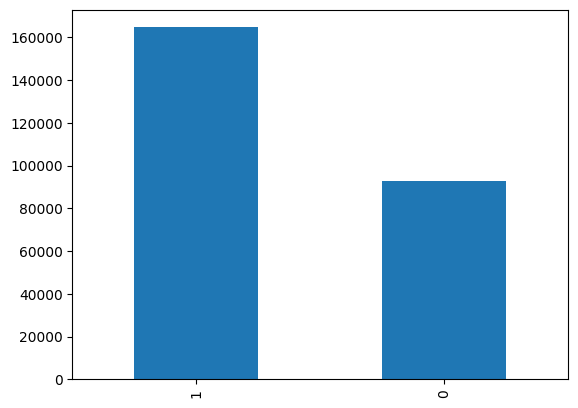

In [ ]:
df['label'].value_counts().plot.bar()

In [ ]:
df['label'].value_counts(normalize=True)


1    0.639077
0    0.360923
Name: label, dtype: float64

### Pre-processing and Feature Selection

The first features to drop are 'id', which is just a feature used for indexing and 'attack_cat', which is just an extension of the target feature.

In [ ]:
df.drop(['id','attack_cat'],axis=1,inplace=True)

We will use the correlation matrix to find other features that might need to be dropped

<Axes: >

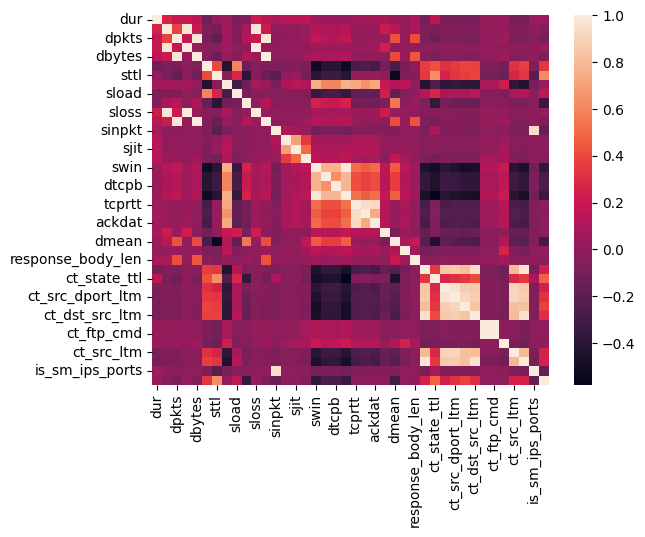

In [ ]:
sns.heatmap(df.select_dtypes(include=['int', 'float']).corr())

In [ ]:
columns = df.select_dtypes(exclude=['object']).columns.tolist()
corr = df.select_dtypes(include=['int', 'float']).corr()
correlated_vars = []
for i in range(len(columns) - 1):
    for j in range(i+1, len(columns)):
        if corr[columns[i]][columns[j]] > 0.95:
            print(columns[i], columns[j], corr[columns[i]][columns[j]])
            correlated_vars.append(columns[j])

spkts sbytes 0.964393217155871
spkts sloss 0.9718594116510776
dpkts dbytes 0.9734453279792796
dpkts dloss 0.979612084935938
sbytes sloss 0.9957715772406667
dbytes dloss 0.996711133831455
swin dwin 0.9804584289136496
ct_srv_src ct_dst_src_ltm 0.9539519771685965
ct_srv_src ct_srv_dst 0.9794668130725528
ct_dst_ltm ct_src_dport_ltm 0.9615176986568883
ct_dst_src_ltm ct_srv_dst 0.9603212131064117
is_ftp_login ct_ftp_cmd 0.9988554882935726


In [ ]:
df = df.drop(columns=correlated_vars)

#### Categorical Features

In [ ]:
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

,proto,service,state
count,257673,257673,257673
unique,133,13,11
top,tcp,-,FIN
freq,123041,141321,117164


Some features have very high cardinalities, and this section reduces the cardinality to 5 or 6 per feature. <br> The logic is to take the top 5 occuring labels in the feature as the labels and set the remainder to '-' (seldom used) labels.

In [ ]:
for feature in df_cat.columns:
    if df_cat[feature].nunique()>6:
        df[feature] = np.where(df[feature].isin(df[feature].value_counts().head().index), df[feature], '-')

In [ ]:
df_cat = df.select_dtypes(exclude=[np.number])
df_cat.describe(include='all')

,proto,service,state
count,257673,257673,257673
unique,6,5,6
top,tcp,-,FIN
freq,123041,149701,117164


In [ ]:
df.head()

,dur,proto,service,state,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,label
0,0.121478,tcp,-,FIN,6,4,74.087490,252,254,14158.942380,8495.365234,24.295600,8.375000,30.177547,11.830604,255,621772692,2202533631,0.000000,0.000000,0.000000,43,43,0,0,1,0,1,1,0,0,1,0,0
1,0.649902,tcp,-,FIN,14,38,78.473372,62,252,8395.112305,503571.312500,49.915000,15.432865,61.426934,1387.778330,255,1417884146,3077387971,0.000000,0.000000,0.000000,52,1106,0,0,43,1,1,1,0,0,1,0,0
2,1.623129,tcp,-,FIN,8,16,14.170161,62,252,1572.271851,60929.230470,231.875571,102.737203,17179.586860,11420.926230,255,2116150707,2963114973,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,0,0,2,0,0
3,1.681642,tcp,-,FIN,12,12,13.677108,62,252,2740.178955,3358.622070,152.876547,90.235726,259.080172,4991.784669,255,1107119177,1047442890,0.000000,0.000000,0.000000,52,64,0,0,1,1,2,1,1,0,2,0,0
4,0.449454,tcp,-,FIN,10,6,33.373826,254,252,8561.499023,3987.059814,47.750333,75.659602,2415.837634,115.807000,255,2436137549,1977154190,0.128381,0.071147,0.057234,53,45,0,0,43,1,2,1,0,0,2,0,0


In [ ]:
df.label.value_counts(normalize=True)

1    0.639077
0    0.360923
Name: label, dtype: float64

### Train test split dataset

In [ ]:
def split_data(df,samples):
    x_0 = df[df.label==0]
    x_1 = df[df.label==1]
    x_0 = x_0.sample(int(0.639077*samples),random_state=123)
    x_1 = x_1.sample(int(0.360923*samples),random_state=123)
    frame = [x_0,x_1]
    new = pd.concat(frame)
    return new

df1 = split_data(df,50000)
df1.reset_index(inplace=True,drop=True)

In [21]:
X = df1.drop(columns='label')
y = df1['label']

In [22]:
train, test, train_labels, test_labels = train_test_split(X,y, test_size=0.3, random_state=42,stratify=y)

In [23]:
train_labels.value_counts(normalize=True)

0    0.639075
1    0.360925
Name: label, dtype: float64

In [24]:
test_labels.to_csv('metadata/datasets/UNSW_NB15_test_labels.csv')

In [25]:
test_labels.value_counts(normalize=True)

0    0.639067
1    0.360933
Name: label, dtype: float64

In [26]:
#train = train.astype(np.float32)
train_labels = train_labels.astype(np.float32)
#test = test.astype(np.float32)
test_labels = test_labels.astype(np.float32)

### Model creation and Training

In [27]:
cat_columns = X.select_dtypes(exclude=[np.number]).columns.tolist()
numeric_columns = X.select_dtypes(exclude=['object']).columns.tolist()

In [28]:
k_folds = 5
batch_size = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.001
weight_decay = 0.1

feature_dimension = 47
num_classes = 1
network_size = [32,32,32]
layers_size = [feature_dimension, *network_size, num_classes]

nn_model = TorchMLP(layers_size=layers_size)

In [ ]:
from modules.optimizer import *

nn = NeuralNetBinaryClassifier(nn_model,criterion=nn.BCELoss(),optimizer=torch.optim.AdamW, max_epochs=10, batch_size=32,verbose=False)

numerical_transformer = Pipeline([
    ('scaler', StandardScaler())
])

label_encoded_transformer = Pipeline([
    ('label_encoder', OrdinalEncoder())
])

one_hot_encoded_transformer = Pipeline([
    ('one_hot_encoder', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer,numeric_columns),
        # ('label',label_encoded_transformer,label_encoded_features),
        ('one_hot', one_hot_encoded_transformer, cat_columns)
    ])

params = {
    "Model__lr": [0.001, 0.01, 0.1],
    "Model__batch_size": (16,64),  # Different batch sizes
    "Model__optimizer": [AdamW, Adam,SGD],  # Different optimizers
    "preprocessor__num__scaler": [StandardScaler(), MinMaxScaler(),RobustScaler()]
}

ml_pipeline = Pipeline([("preprocessor", preprocessor),
                        ('float32', FunctionTransformer(func=convert_to_float32)), 
                        ("Model", nn)])

optimizer = ModelOptimizer(ml_pipeline,param_grid=params,optimization_algorithm='grid_search')
opt = optimizer.optimize(train,train_labels)

In [29]:
# Load the pretrained model from the above cell

import joblib


# joblib.dump(opt, 'optimizer_fullgrid.pkl')

opt = joblib.load('metadata/proxy_data_models/optimizer_fullgrid.pkl')

Accuracy Score is 0.9208666666666666


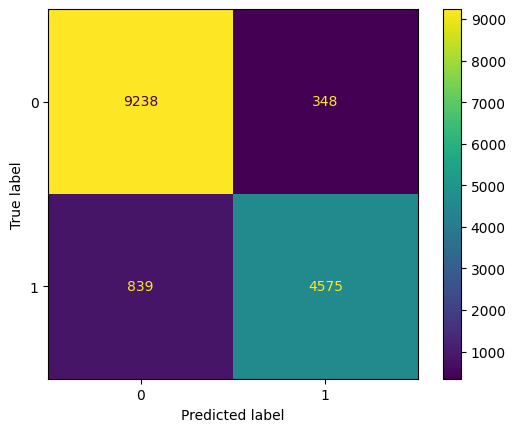

In [30]:
from sklearn.metrics import accuracy_score
torch_model = opt.best_estimator_.named_steps['Model'].module
torch_model.eval()
pred_probabilities = torch_model(torch.tensor(opt.best_estimator_.named_steps['preprocessor'].transform(test).astype(float), dtype=torch.float)).detach()

pred_y_test = [1 if prob > 0.5 else 0 for prob in pred_probabilities]
print(f'Accuracy Score is {accuracy_score(test_labels,pred_y_test)}')
cm = confusion_matrix(torch.tensor(test_labels.to_numpy(), dtype=torch.float64), pred_y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot();

In [31]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred_y_test))

              precision    recall  f1-score   support

         0.0       0.92      0.96      0.94      9586
         1.0       0.93      0.85      0.89      5414

    accuracy                           0.92     15000
   macro avg       0.92      0.90      0.91     15000
weighted avg       0.92      0.92      0.92     15000



## Proxy Model creation for PDP-ALE and Counterfactual Explanations

In [32]:
# proxy model for PDP-ALE
surrogate_model_accuracy = proxy_model(opt.param_grid,opt,'accuracy','XGBoostRegressor')

In [33]:
import joblib
joblib.dump(surrogate_model_accuracy,'metadata/proxy_data_models/UNSW_pdp_ale_proxy.pkl')

['metadata/proxy_data_models/UNSW_pdp_ale_proxy.pkl']

In [34]:
missclassified = pd.concat([test, test_labels.rename('GroundTruth')], axis=1).reset_index(drop=True)
missclassified['Predicted'] = pred_y_test
missclassified['Label'] = (missclassified['GroundTruth'] != missclassified['Predicted']).astype(int)
missclassified[missclassified['Label']==1]

,dur,proto,service,state,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,GroundTruth,Predicted,Label
14,0.000005,udp,-,INT,2,0,200000.005100,254,0,1.190400e+09,0.000000,0.005000,0.000000,0.000000,0.000000,0,0,0,0.000000,0.000000,0.000000,744,0,0,0,7,2,3,1,0,0,3,0,0.0,1,1
29,1.143700,tcp,-,FIN,12,10,18.361458,254,252,6.875929e+03,5036.285645,100.863365,115.126336,5732.626252,173.282219,255,236074496,812774027,0.193907,0.107562,0.086345,89,80,0,0,2,1,1,1,0,0,1,0,1.0,0,1
58,0.465525,tcp,-,FIN,10,6,32.221685,254,252,8.454970e+03,3849.417236,48.101667,76.572602,2660.764571,108.595250,255,1627130977,2703738176,0.118948,0.082659,0.036289,55,45,0,0,4,1,1,1,0,0,19,0,1.0,0,1
63,0.000002,udp,-,INT,2,0,500000.001300,254,0,2.128000e+09,0.000000,0.002000,0.000000,0.000000,0.000000,0,0,0,0.000000,0.000000,0.000000,532,0,0,0,6,2,3,1,0,0,1,0,0.0,1,1
70,0.868895,tcp,http,FIN,10,10,21.866854,62,252,6.794837e+03,11205.036130,96.543889,73.084891,5490.323121,133.384547,255,2446213939,879132258,0.282575,0.209877,0.072698,82,135,1,231,5,1,1,1,0,1,2,0,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14918,0.000003,udp,-,INT,2,0,333333.321500,254,0,1.093333e+08,0.000000,0.003000,0.000000,0.000000,0.000000,0,0,0,0.000000,0.000000,0.000000,41,0,0,0,3,2,1,1,0,0,3,0,1.0,0,1
14941,0.834039,tcp,http,FIN,10,8,20.382741,62,252,7.376154e+03,8747.792969,92.671000,110.026859,5564.163379,207.202719,255,2732631151,1492297850,0.147217,0.063095,0.084122,85,130,1,112,1,1,1,1,0,1,1,0,1.0,0,1
14955,1.042794,tcp,-,FIN,10,8,16.302357,254,252,3.897222e+03,2378.226318,115.834556,138.461422,6742.662378,194.893031,255,1211847443,1210301397,0.174231,0.073559,0.100672,56,44,0,0,1,1,1,1,0,0,1,0,1.0,0,1
14956,0.453857,tcp,http,FIN,10,8,37.456732,62,252,1.292037e+04,18261.257810,50.428556,51.000855,2539.543066,78.373117,255,1290027557,1952467037,0.139966,0.096132,0.043834,81,148,1,173,1,1,1,1,0,1,2,0,1.0,0,1


In [35]:
misclassified_instance = missclassified.drop(columns=['GroundTruth','Label','Predicted']).loc[14]

In [36]:
# proxy_model and dataset for counterfactual explanations
# proxy_model , proxy_dataset = instance_proxy(train,train_labels,opt, misclassified_instance,opt.param_grid)

In [38]:
# # load the pre trained proxy model and dataset from the above cell
# import joblib
# proxy_model = joblib.load('proxy_data_models/cfproxy_model_grid.pkl')
# proxy_dataset = pd.read_csv('proxy_data_models/cfproxy_dataset_grid.csv')

In [39]:
def preprocess_data(data,one_hot_encoded_features,numerical_features):

    #one hot encoding of choosen features
    new_data = pd.concat([data, pd.get_dummies(data[one_hot_encoded_features],dtype=int)], axis=1)
    new_data = new_data.drop(columns=one_hot_encoded_features)

    scaler = StandardScaler()
    new_data[numerical_features] = scaler.fit_transform(new_data[numerical_features])
    
    return new_data

In [40]:
new_train = preprocess_data(train,cat_columns,numeric_columns)
new_test = preprocess_data(test,cat_columns,numeric_columns)

In [41]:
new_train.reset_index(drop=True,inplace=True)
new_test.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

train_labels.reset_index(drop=True,inplace=True)
test_labels.reset_index(drop=True,inplace=True)

## Create gRPC Client

### Run `python xai_server.py` command on terminal in order to start server

### Compute PDP 1D Plots via gRPC

In [3]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,features,xAxis,yAxis = client.get_explanations(explanation_type='Pipeline',explanation_method='PDPlots',model='UNSW_NB15_model', feature1='preprocessor__num__scaler')

### Compute PDP 2D Plots via gRPC

In [4]:
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,features,xAxis,yAxis,zAxis= client.get_explanations(explanation_type='Pipeline',explanation_method='2D_PDPlots',model='UNSW_NB15_model',feature1='Model__batch_size',feature2='preprocessor__num__scaler')

### Compute ALE Plots via gRPC

In [5]:
client = Client()
explainability_type,explanation_method,explainability_model,plot_name,plot_descr,plot_type,features,xAxis,yAxis = client.get_explanations(explanation_type='Pipeline',explanation_method='ALEPlots',model='UNSW_NB15_model',feature1='preprocessor__num__scaler')

### Compute Influence Functions via gRPC

In [15]:
# Compute influences via gRPC
import io
client = Client()
positive, negative = client.get_explanations(explanation_type='Pipeline',explanation_method='InfluenceFunctions', model = 'UNSW_NB15_model', num_influential=5)
#inf = pd.DataFrame(np.array(inf).reshape(6,5000),columns=[str(i) for i in range(0, 5000)])
# positive =  pd.read_parquet(io.BytesIO(positive))
# negative =  pd.read_parquet(io.BytesIO(negative))

Start
Stopped Sending


In [5]:
positive

'[{"dur":0.0768790681,"spkts":-0.0971396112,"dpkts":-0.1499238738,"rate":-0.4375205128,"sttl":1.004452328,"dttl":1.567106097,"sload":-0.2935775105,"dload":-0.3667986633,"sinpkt":-0.1496974281,"dinpkt":0.0345098879,"sjit":0.0410472207,"djit":-0.0820364838,"swin":0.8457167832,"stcpb":-0.339167621,"dtcpb":-0.3636681959,"tcprtt":2.4624244645,"synack":1.9171796172,"ackdat":2.725868372,"smean":-0.2407115872,"dmean":-0.2825321432,"trans_depth":-0.3291647154,"response_body_len":-0.0555042573,"ct_srv_src":-0.6327472673,"ct_state_ttl":-0.042283972,"ct_dst_ltm":-0.5838790915,"ct_dst_sport_ltm":-0.3760145692,"is_ftp_login":-0.1116622048,"ct_flw_http_mthd":-0.2056815211,"ct_src_ltm":-0.5102825819,"is_sm_ips_ports":-0.1588117161,"proto_-":0,"proto_arp":0,"proto_ospf":0,"proto_tcp":1,"proto_udp":0,"proto_unas":0,"service_-":1,"service_dns":0,"service_ftp-data":0,"service_http":0,"service_smtp":0,"state_-":0,"state_CON":0,"state_FIN":1,"state_INT":0,"state_REQ":0,"state_RST":0,"label":1.0,"influence":

In [5]:
negative

,dur,spkts,dpkts,rate,sttl,dttl,sload,dload,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_dst_sport_ltm,is_ftp_login,ct_flw_http_mthd,ct_src_ltm,is_sm_ips_ports,proto_-,proto_arp,proto_ospf,proto_tcp,proto_udp,proto_unas,service_-,service_dns,service_ftp-data,service_http,service_smtp,state_-,state_CON,state_FIN,state_INT,state_REQ,state_RST,label,influence
25,-0.095590,-0.097140,-0.129970,-0.437354,1.004452,1.567106,-0.293569,-0.365526,-0.159382,-0.048839,-0.047586,-0.126867,0.845717,0.399261,0.013402,0.324447,0.221468,0.397802,-0.458302,-0.381540,-0.329165,-0.055504,-0.632747,-0.042284,-0.583879,-0.376015,-0.111662,-0.205682,-0.654007,-0.158812,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0.0,-13.992065
85,-0.094506,-0.113693,-0.169877,-0.437424,1.004452,1.567106,-0.293573,-0.366798,-0.158299,-0.021706,-0.037228,-0.107386,0.845717,0.059280,0.576257,0.538566,0.124841,0.961634,-0.433576,-0.427509,-0.329165,-0.055504,-0.740588,-0.042284,-0.583879,-0.376015,-0.111662,-0.205682,-0.654007,-0.158812,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0.0,-9.892536
402,-0.139188,-0.113693,-0.189831,-0.437342,1.004452,1.567106,-0.293435,-0.366594,-0.160925,-0.039271,-0.069519,-0.119544,0.845717,1.035692,2.006587,0.364234,0.292336,0.392339,0.140071,-0.423972,-0.329165,-0.055504,-0.632747,-0.042284,-0.583879,-0.376015,-0.111662,-0.205682,-0.654007,-0.158812,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0.0,-7.819713
248,-0.211922,-0.179905,-0.249691,1.043338,1.004452,-0.777691,0.180207,-0.368023,-0.165923,-0.089551,-0.111591,-0.142531,-1.182572,-0.857368,-0.856445,-0.438666,-0.386913,-0.429279,-0.438521,-0.583093,-0.329165,-0.055504,-0.632747,0.846543,-0.583879,-0.376015,-0.111662,-0.205682,-0.654007,-0.158812,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.0,-7.164919
610,-0.211922,-0.179905,-0.249691,1.043338,1.004452,-0.777691,0.180207,-0.368023,-0.165923,-0.089551,-0.111591,-0.142531,-1.182572,-0.857368,-0.856445,-0.438666,-0.386913,-0.429279,-0.438521,-0.583093,-0.329165,-0.055504,-0.632747,0.846543,-0.583879,-0.376015,-0.111662,-0.205682,-0.654007,-0.158812,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.0,-7.164919


### Counterfactual Explanations via gRPC

In [58]:
proxy_dataset.drop(columns='Unnamed: 0',inplace=True)
proxy_dataset.head()

,BinaryLabel,Model__batch_size,Model__lr,Model__optimizer,preprocessor__num__scaler
0,0,16,0.001,<class 'torch.optim.adamw.AdamW'>,StandardScaler()
1,0,16,0.001,<class 'torch.optim.adamw.AdamW'>,MinMaxScaler()
2,0,16,0.001,<class 'torch.optim.adamw.AdamW'>,RobustScaler()
3,0,16,0.001,<class 'torch.optim.adam.Adam'>,StandardScaler()
4,0,16,0.001,<class 'torch.optim.adam.Adam'>,MinMaxScaler()


In [59]:
query = pd.DataFrame.from_dict(opt.best_params_,orient='index').T
query['preprocessor__num__scaler'] = query['preprocessor__num__scaler'].astype(str)
query['Model__optimizer'] = query['Model__optimizer'].astype(str)
query['Model__lr'] = query['Model__lr'].astype(str)

query['Model__batch_size'] = query['Model__batch_size'].astype(np.int64)


In [60]:
query

,Model__batch_size,Model__lr,Model__optimizer,preprocessor__num__scaler
0,64,0.01,<class 'torch.optim.adam.Adam'>,StandardScaler()


In [61]:
proxy_dataset['Model__lr'] = proxy_dataset['Model__lr'].astype(str)

In [11]:
client = Client()
cfs = client.get_explanations(explanation_type='Pipeline',explanation_method='CounterfactualExplanations',model='UNSW_NB15_model')

In [63]:
query

,Model__batch_size,Model__lr,Model__optimizer,preprocessor__num__scaler
0,64,0.01,<class 'torch.optim.adam.Adam'>,StandardScaler()


In [64]:
cfs =  pd.read_parquet(io.BytesIO(cfs))
cfs

,Model__batch_size,Model__lr,Model__optimizer,preprocessor__num__scaler,BinaryLabel
0,22,0.01,<class 'torch.optim.adam.Adam'>,MinMaxScaler(),0
1,36,0.001,<class 'torch.optim.adam.Adam'>,StandardScaler(),0
2,20,0.01,<class 'torch.optim.adam.Adam'>,StandardScaler(),0
3,36,0.01,<class 'torch.optim.adamw.AdamW'>,StandardScaler(),0
4,58,0.01,<class 'torch.optim.adam.Adam'>,MinMaxScaler(),0


## Model Explainability

### PDPlots and 2D PDPlots via gRPC

In [6]:
client = Client()
pdp_vals, pdp_effect = client.get_explanations(explanation_type='Model',explanation_method='PDPlots',
                                                  model = 'UNSW_NB15_model', feature1='proto')
pdp_vals = json.loads(pdp_vals)
pdp_effect = json.loads(pdp_effect)


Stopped Sending


In [7]:
pdp_vals = [np.array(v) for v in pdp_vals]
pdp_effect = [np.array(v) for v in pdp_effect]

<BarContainer object of 6 artists>

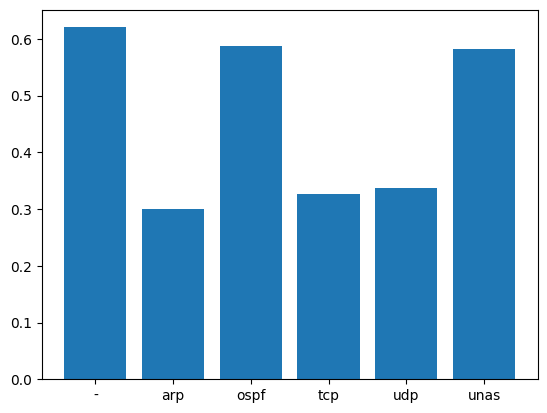

In [8]:
plt.bar(pdp_vals[0],pdp_effect[0])

In [13]:
client = Client()
client = Client()
pdp_vals, pdp_effect = client.get_explanations(explanation_type='Model',explanation_method='PDPlots',
                                                  model = 'UNSW_NB15_model', feature1='dur')
pdp_vals = json.loads(pdp_vals)
pdp_effect = json.loads(pdp_effect)


pdp_vals = [np.array(v) for v in pdp_vals]
pdp_effect = [np.array(v) for v in pdp_effect]

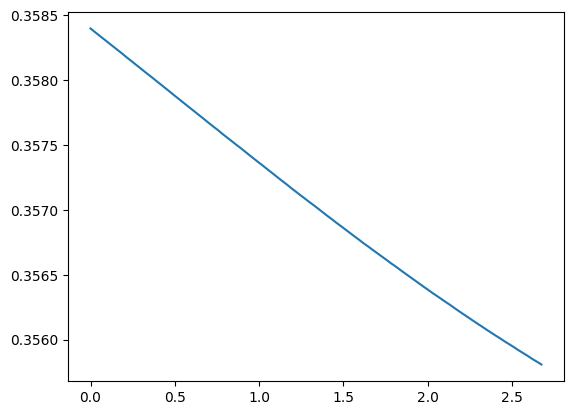

In [12]:
plt.plot(pdp_vals[0],pdp_effect[0])

## CounterfactualsExplanations via gRPC

In [70]:
data = pd.concat([train.reset_index(), train_labels], axis = 1)

In [44]:
# client = Client()
# cfs = client.get_explanations(explanation_type='Model',explanation_method='CounterfactualExplanations',query=misclassified_instance.to_frame().T.astype(train.dtypes),model='UNSW_NB15_model',target='label')

### ALE plots via gRPC

In [45]:
client = Client()
ale_data = client.get_explanations(explanation_type='Model',explanation_method='ALEPlots',
                                                  model = 'UNSW_NB15_model', feature1='proto')
json_data_list = json.loads(ale_data)

# Create a list to store dataframes
dataframes_list_deserialized = []

# Convert each dictionary back into a dataframe
for json_data in json_data_list:
    df = pd.read_json(json_data, orient='split')
    dataframes_list_deserialized.append(df)

Stopped Sending


In [73]:
dataframes_list_deserialized[0]

,eff,size,lowerCI_95%,upperCI_95%
arp,-77.508925,900,NaN,NaN
unas,-77.277083,1179,-77.295238,-77.258928
-,-77.270308,1478,-77.273429,-77.267187
ospf,-76.836881,287,-77.327400,-76.346361
udp,8.024457,10747,5.782097,10.266817
tcp,10.333525,20408,10.065341,10.601709
